In [35]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/tf/ProjectGabriel/pilca")
import matplotlib.pyplot as plt
import os
import json
import datetime
import numpy as np
import torch
import pandas as pd

import utils.torchphysics as tp
import utils.utils as ut 
import torch
from lightcurve_fitting import filters as flc
import utils.analysis as an

torch.set_default_dtype(torch.float64)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
BASE_DIR = os.path.join(ut.storage_parent_path, "experiments")
EXP_NAME = "TEST_1"
EXPERIMENTS_DIR = os.path.join(ut.storage_parent_path, "experiments", EXP_NAME)

In [37]:
all_filters = ["z", "y", "i", "r", "g", "u", "uvw1"][::-1]  # from red to UV
mjd_array = np.linspace(3, 13, 600)


filter_combinations = [all_filters[:i+1] for i in range(len(all_filters))]

max_days = 10
time_spans = np.arange(1, max_days + 1)  # [1, 2, ..., 10]

model_parameters = [1.2, 2., 4.0, 2.5]

# --- setup light curve builder ---
builder = ut.LCBuilder(
    model_name="sc4",
    model_parameters=model_parameters,
    model_units=[1,1,1,1],
    seed=42
)

lc = builder.build_sim_lc(
    mjd_array=mjd_array,
    filters_list=all_filters,  # full set
    redshift=0.00526,
    dlum_factor=1e-1/2,
    dm=31.1,
    dL=19.,
    dLerr=2.9
)

In [38]:
# ==============================================
# 1. Collect all experiments
# ==============================================
records = []

for exp in sorted([f for f in os.listdir(EXPERIMENTS_DIR) if f.startswith("exp_")]):
    exp_path = os.path.join(EXPERIMENTS_DIR, exp)

    if not os.path.isdir(exp_path):
        continue

    config_path = os.path.join(exp_path, "exp_config.json")
    loss_csv_path = os.path.join(exp_path, "history.csv")
    summary_path = os.path.join(exp_path, "summary.txt")

    if not os.path.exists(config_path):
        continue

    with open(config_path, "r") as f:
        cfg = json.load(f)

    # Load last loss value (if available)
    if os.path.exists(loss_csv_path):
        loss_df = pd.read_csv(loss_csv_path)
        final_loss = loss_df["loss"].iloc[-1]
    else:
        raise Exception("No loss found")

    summary = ""
    if os.path.exists(summary_path):
        with open(summary_path, "r") as f:
            summary = f.read().strip()

    records.append({
        "exp_name": exp,
        "filters": "-".join(cfg.get("filters", [])),
        "time_span": cfg.get("time_span"),
        "final_loss": final_loss,
        "n_points": cfg.get("n_points", None),
        "summary": summary
    })


KeyboardInterrupt: 

In [ ]:
records



[{'exp_name': 'exp__filters-uvw1-u-g-r-i_time-1d',
  'filters': 'uvw1-u-g-r-i',
  'time_span': 1.0,
  'final_loss': -52.177771417414,
  'n_points': 43.0,
  'summary': "Filters=['uvw1', 'u', 'g', 'r', 'i'], Time=1d, Final loss=-52.1778"},
 {'exp_name': 'exp__filters-uvw1-u-g-r-i_time-2d',
  'filters': 'uvw1-u-g-r-i',
  'time_span': 2.0,
  'final_loss': -51.82001055690103,
  'n_points': 84.0,
  'summary': "Filters=['uvw1', 'u', 'g', 'r', 'i'], Time=2d, Final loss=-51.8200"},
 {'exp_name': 'exp__filters-uvw1-u-g-r-i_time-3d',
  'filters': 'uvw1-u-g-r-i',
  'time_span': 3.0,
  'final_loss': -34.1131792564521,
  'n_points': 126.0,
  'summary': "Filters=['uvw1', 'u', 'g', 'r', 'i'], Time=3d, Final loss=-34.1132"},
 {'exp_name': 'exp__filters-uvw1-u-g-r-i_time-4d',
  'filters': 'uvw1-u-g-r-i',
  'time_span': 4.0,
  'final_loss': -36.80774326187475,
  'n_points': 168.0,
  'summary': "Filters=['uvw1', 'u', 'g', 'r', 'i'], Time=4d, Final loss=-36.8077"},
 {'exp_name': 'exp__filters-uvw1-u-g-r_ti

In [ ]:

# ==============================================
# 📊 2. Create summary dataframe
# ==============================================
df = pd.DataFrame(records)
df = df.sort_values(by=["filters", "time_span"]).reset_index(drop=True)
print(f"Loaded {len(df)} experiments.")
display(df.head())

# Save master summary CSV
summary_csv = os.path.join(EXPERIMENTS_DIR, "summary_all.csv")
df.to_csv(summary_csv, index=False)
print(f"Summary saved to: {summary_csv}")


Loaded 38 experiments.


,exp_name,filters,time_span,final_loss,n_points,summary
0,exp__filters-uvw1_time-1d,uvw1,1.0,-32.551521,6.0,"Filters=['uvw1'], Time=1d, Final loss=-32.5515"
1,exp__filters-uvw1_time-2d,uvw1,2.0,-59.695030,11.0,"Filters=['uvw1'], Time=2d, Final loss=-59.6950"
2,exp__filters-uvw1_time-3d,uvw1,3.0,-43.900360,24.0,"Filters=['uvw1'], Time=3d, Final loss=-43.9004"
3,exp__filters-uvw1_time-4d,uvw1,4.0,-41.332421,33.0,"Filters=['uvw1'], Time=4d, Final loss=-41.3324"
4,exp__filters-uvw1_time-5d,uvw1,5.0,-33.652983,45.0,"Filters=['uvw1'], Time=5d, Final loss=-33.6530"


Summary saved to: /tf/astrodados2/pilca.storage/experiments/TEST_1/summary_all.csv


In [ ]:
df

,exp_name,filters,time_span,final_loss,n_points,summary
0,exp__filters-uvw1_time-1d,uvw1,1.0,-3.255152e+01,6.0,"Filters=['uvw1'], Time=1d, Final loss=-32.5515"
1,exp__filters-uvw1_time-2d,uvw1,2.0,-5.969503e+01,11.0,"Filters=['uvw1'], Time=2d, Final loss=-59.6950"
2,exp__filters-uvw1_time-3d,uvw1,3.0,-4.390036e+01,24.0,"Filters=['uvw1'], Time=3d, Final loss=-43.9004"
3,exp__filters-uvw1_time-4d,uvw1,4.0,-4.133242e+01,33.0,"Filters=['uvw1'], Time=4d, Final loss=-41.3324"
4,exp__filters-uvw1_time-5d,uvw1,5.0,-3.365298e+01,45.0,"Filters=['uvw1'], Time=5d, Final loss=-33.6530"
5,exp__filters-uvw1_time-6d,uvw1,6.0,-2.200790e+01,59.0,"Filters=['uvw1'], Time=6d, Final loss=-22.0079"
6,exp__filters-uvw1_time-7d,uvw1,7.0,-3.514050e+01,69.0,"Filters=['uvw1'], Time=7d, Final loss=-35.1405"
7,exp__filters-uvw1_time-8d,uvw1,8.0,3.385596e+01,79.0,"Filters=['uvw1'], Time=8d, Final loss=33.8560"
8,exp__filters-uvw1_time-9d,uvw1,9.0,6.650105e+00,83.0,"Filters=['uvw1'], Time=9d, Final loss=6.6501"
9,exp__filters-uvw1_time-10d,uvw1,10.0,-2.677804e+01,91.0,"Filters=['uvw1'], Time=10d, Final loss=-26.7780"


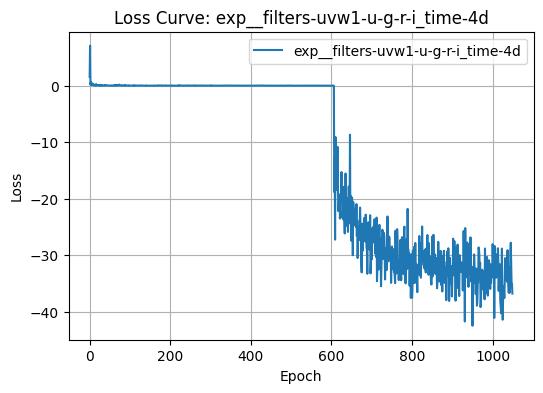

In [ ]:

# ==============================================
# 📈 3. Visualize loss evolution per experiment
# ==============================================
def plot_loss(exp_name):
    exp_path = os.path.join(EXPERIMENTS_DIR, exp_name)
    loss_csv_path = os.path.join(exp_path, "history.csv")
    if not os.path.exists(loss_csv_path):
        print("No loss history for:", exp_name)
        return
    df_loss = pd.read_csv(loss_csv_path)
    plt.figure(figsize=(6,4))
    plt.plot(df_loss["loss"], label=exp_name)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve: {exp_name}")
    plt.grid(True)
    plt.legend()
    plt.show()
# Example: plot the last experiment's loss
plot_loss(df.iloc[-1]["exp_name"])

In [ ]:
all_filters = ["z", "y", "i", "r", "g", "u", "uvw1"][::-1]  # from red to UV
max_days = 10
time_spans = np.arange(1, max_days + 1)
filter_combinations = [all_filters[:i+1] for i in range(len(all_filters))]

metrics = ["loss", "chi2", "cdf", "perdev"]

# Initialize result dictionary
result_dict = {m: {filt: np.full(len(time_spans), np.nan, dtype=object) for filt in all_filters} for m in metrics}

for filt_subset in filter_combinations:
    last_f = filt_subset[-1]

    for i, tspan in enumerate(time_spans):
        suffix = f"_filters-{'-'.join(filt_subset)}_time-{tspan}d"
        ename = f"exp_{suffix}"
        exp_dir = os.path.join(EXPERIMENTS_DIR, ename)
        if not os.path.isdir(exp_dir):
            continue

        # Find row in df
        row = df[df["exp_name"] == ename]
        if row.empty:
            continue

        # --- Store scalar loss ---
        result_dict["loss"][last_f][i] = row.final_loss.values[0]

        # --- Load samples and compute metrics ---
        samples = np.load(os.path.join(exp_dir, "samples.npy"))
        res = an.evaluate_sampling(lc, model_name="sc4", samples=samples, true_p=model_parameters)

        # Store results
        # chi2 = res["chi2"]
        # print(chi2)
        # aaa
        result_dict["chi2"][last_f][i] = res["chi2"] if res["chi2"]<2 else np.nan
        result_dict["cdf"][last_f][i] = res["cdf"]   # vector per parameter
        result_dict["perdev"][last_f][i] = res["perdev"]  # vector per parameter

# --- Convert to DataFrames for each metric ---
df_loss  = pd.DataFrame({f: result_dict["loss"][f]  for f in all_filters})
df_chi2  = pd.DataFrame({f: result_dict["chi2"][f]  for f in all_filters})
df_cdf   = pd.DataFrame({f: result_dict["cdf"][f]   for f in all_filters})
df_pdev  = pd.DataFrame({f: result_dict["perdev"][f] for f in all_filters})

# Example: access cdf for filter 'r' and time span 5
print(df_cdf["r"][4])  # vector of per-parameter cdf values



nan


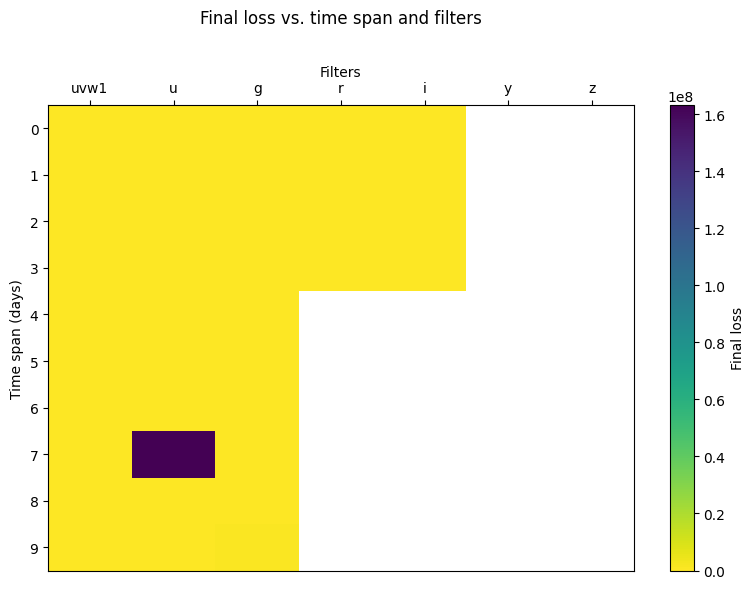

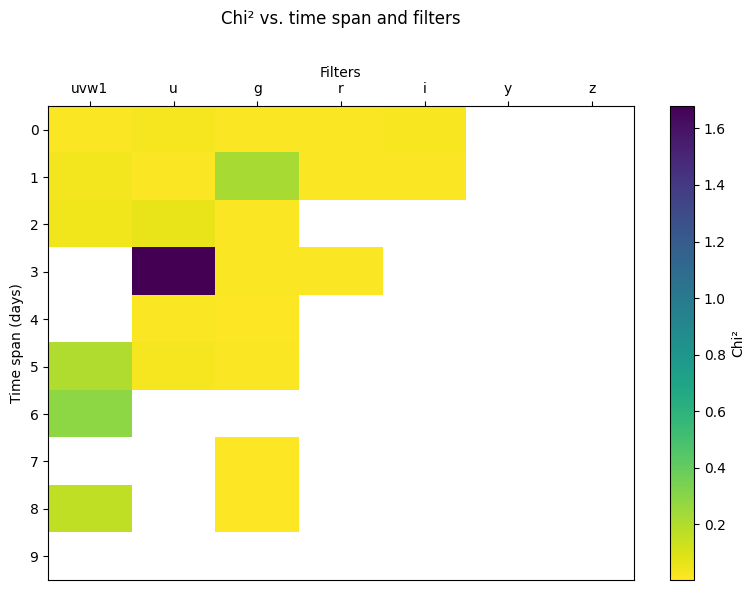

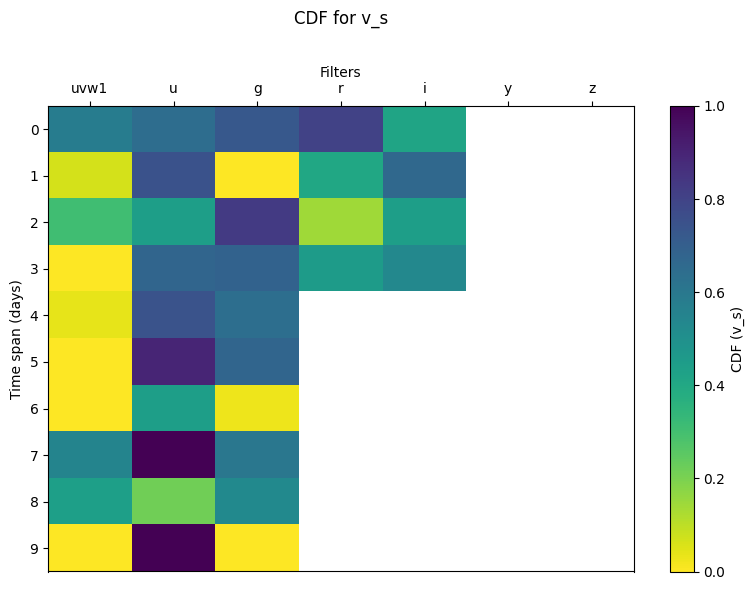

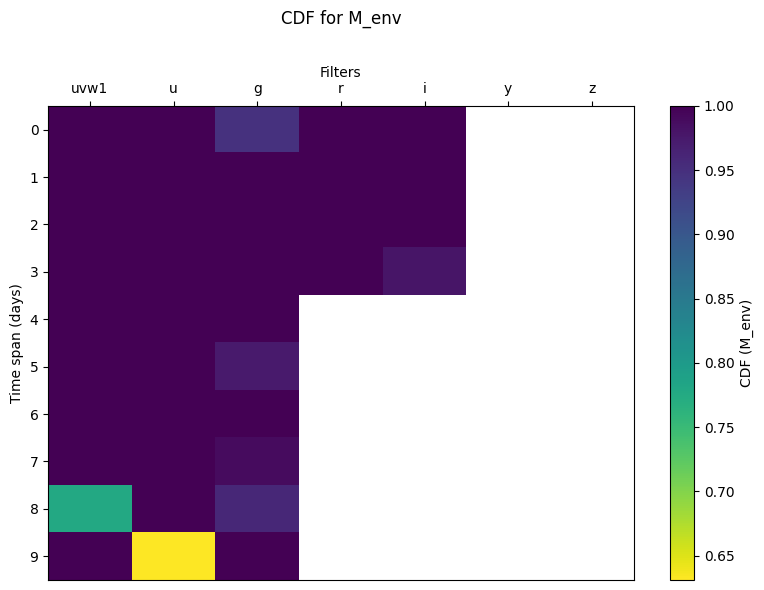

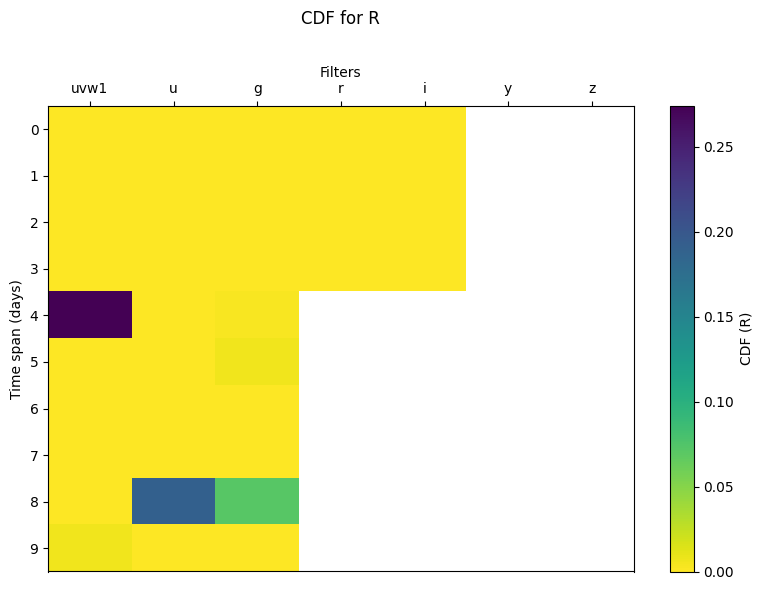

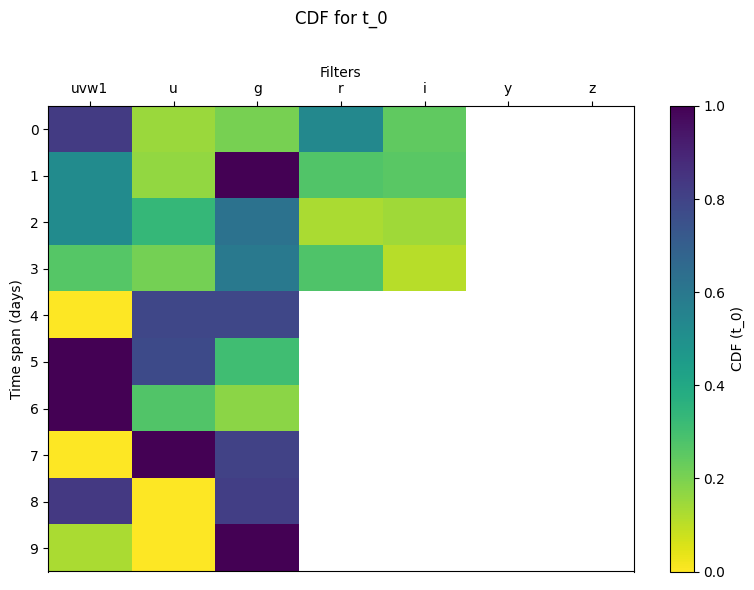

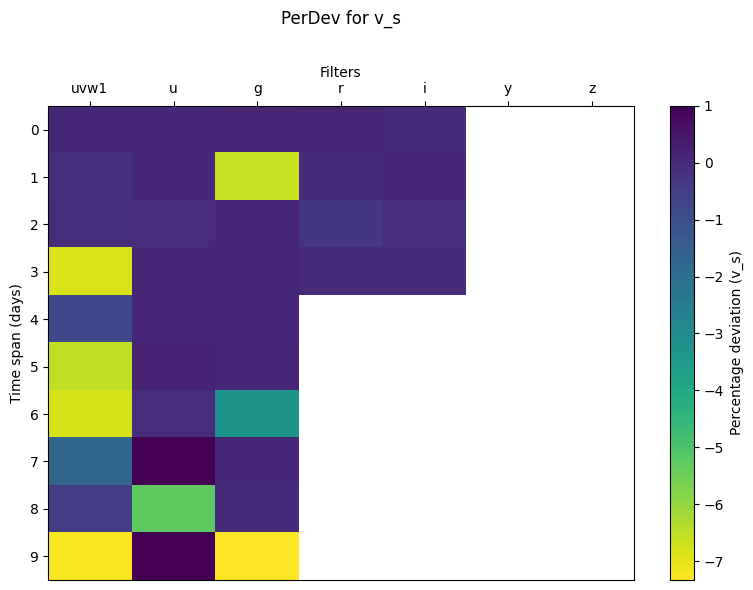

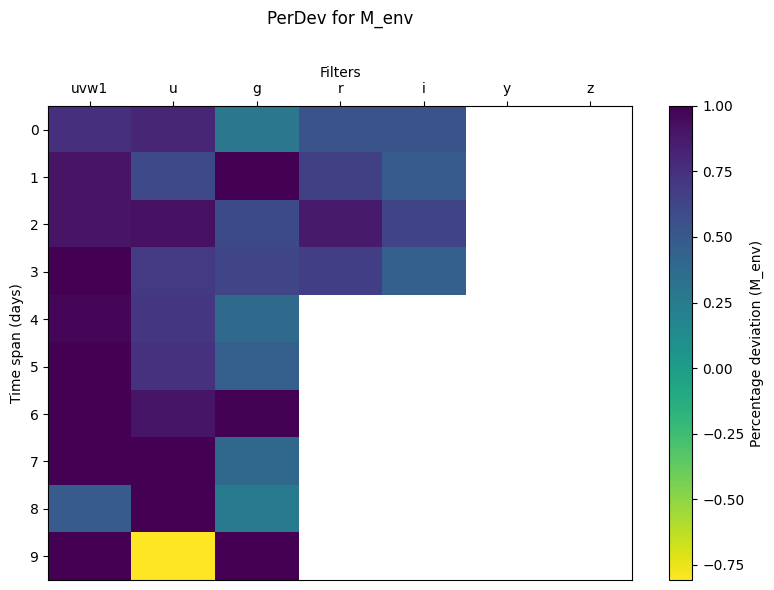

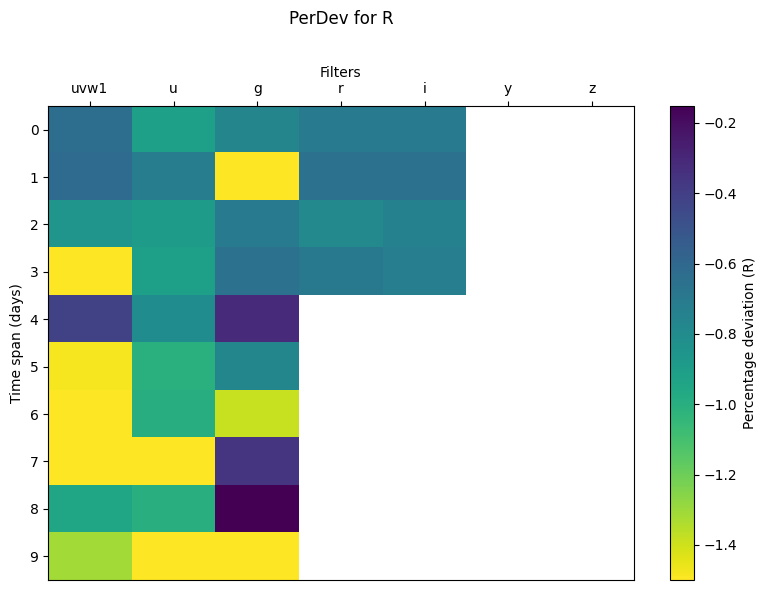

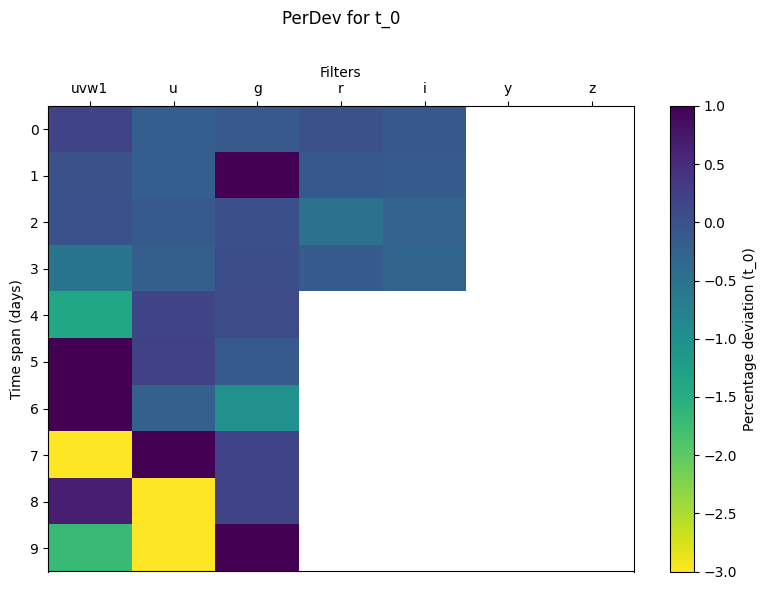

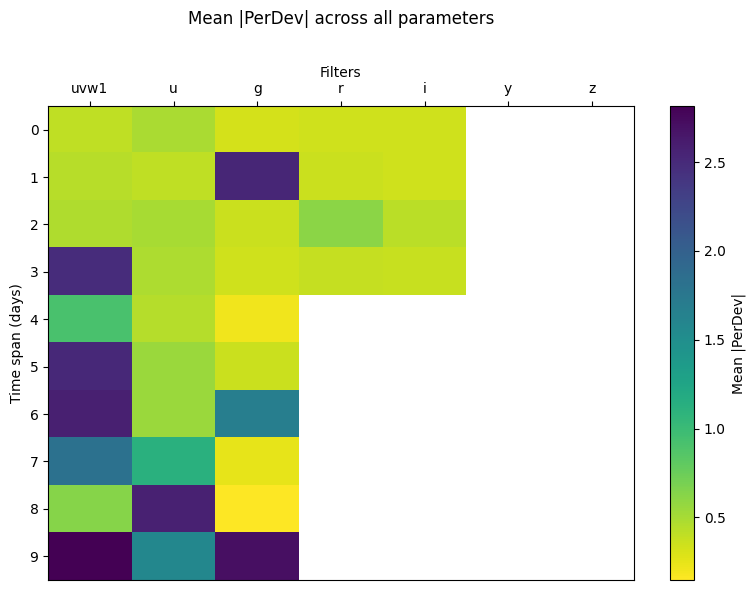

In [ ]:
param_names = ["v_s", "M_env", "R", "t_0"]

def plot_heatmap(matrix, title, cbar_label, cmap="viridis_r", vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(matrix.astype(float), aspect="auto", cmap=cmap, origin="upper", vmin=vmin, vmax=vmax)

    ax.set_xticks(np.arange(len(matrix.columns)))
    ax.set_xticklabels(matrix.columns)
    ax.set_yticks(np.arange(len(matrix.index)))
    ax.set_yticklabels(matrix.index)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_xlabel("Filters")
    ax.set_ylabel("Time span (days)")

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label)
    plt.title(title, pad=30)
    plt.tight_layout()
    plt.show()

# ===================================================
# Helper to safely extract numeric arrays
# ===================================================
def safe_extract(df_metric, index, col, param_idx=None):
    val = df_metric.iloc[index, col]
    if isinstance(val, (list, np.ndarray)):
        if param_idx is not None and len(val) > param_idx:
            return float(val[param_idx])
        return np.nanmean(val).astype(float)
    try:
        return float(val)
    except (TypeError, ValueError):
        return np.nan

# 1️⃣ Global metrics
plot_heatmap(df_loss.fillna(np.nan), "Final loss vs. time span and filters", "Final loss")
plot_heatmap(df_chi2.fillna(np.nan), "Chi² vs. time span and filters", "Chi²")

# 2️⃣ Per-parameter CDF and PerDev
for mname, df_metric, label in [("CDF", df_cdf, "CDF"), ("PerDev", df_pdev, "Percentage deviation")]:
    for i, pname in enumerate(param_names):
        values = np.full((len(df_metric.index), len(df_metric.columns)), np.nan)
        for r in range(len(df_metric.index)):
            for c in range(len(df_metric.columns)):
                values[r, c] = safe_extract(df_metric, r, c, param_idx=i)
        temp_df = pd.DataFrame(values, index=df_metric.index, columns=df_metric.columns)
        plot_heatmap(temp_df, f"{mname} for {pname}", f"{label} ({pname})")

# 3️⃣ Global mean absolute perdev
values = np.full((len(df_pdev.index), len(df_pdev.columns)), np.nan)
for r in range(len(df_pdev.index)):
    for c in range(len(df_pdev.columns)):
        val = df_pdev.iloc[r, c]
        if isinstance(val, (list, np.ndarray)):
            try:
                values[r, c] = np.nanmean(np.abs(val)).astype(float)
            except:
                values[r, c] = np.nan
        else:
            try:
                values[r, c] = abs(float(val))
            except:
                values[r, c] = np.nan
global_perdev_df = pd.DataFrame(values, index=df_pdev.index, columns=df_pdev.columns)
plot_heatmap(global_perdev_df, "Mean |PerDev| across all parameters", "Mean |PerDev|")

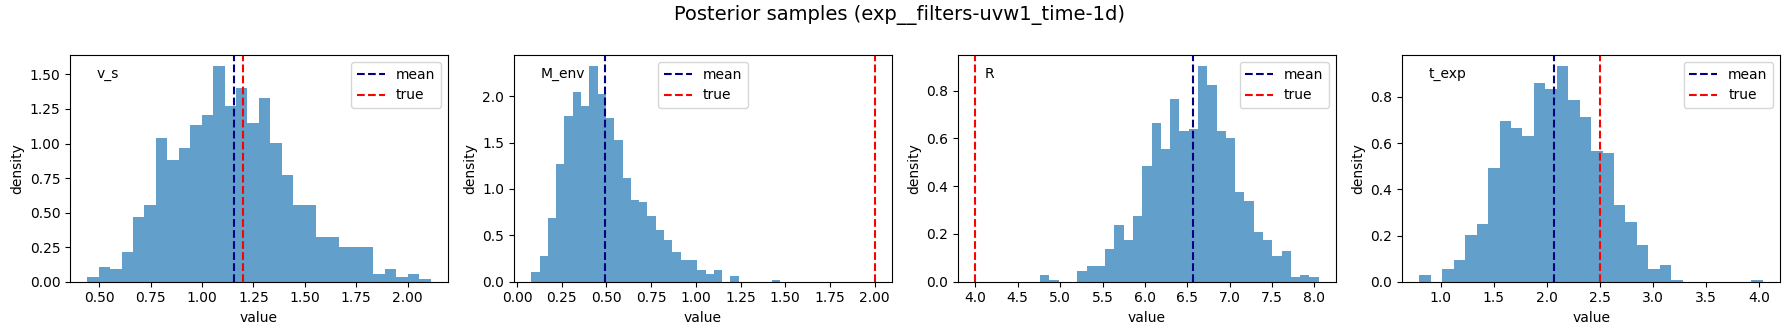

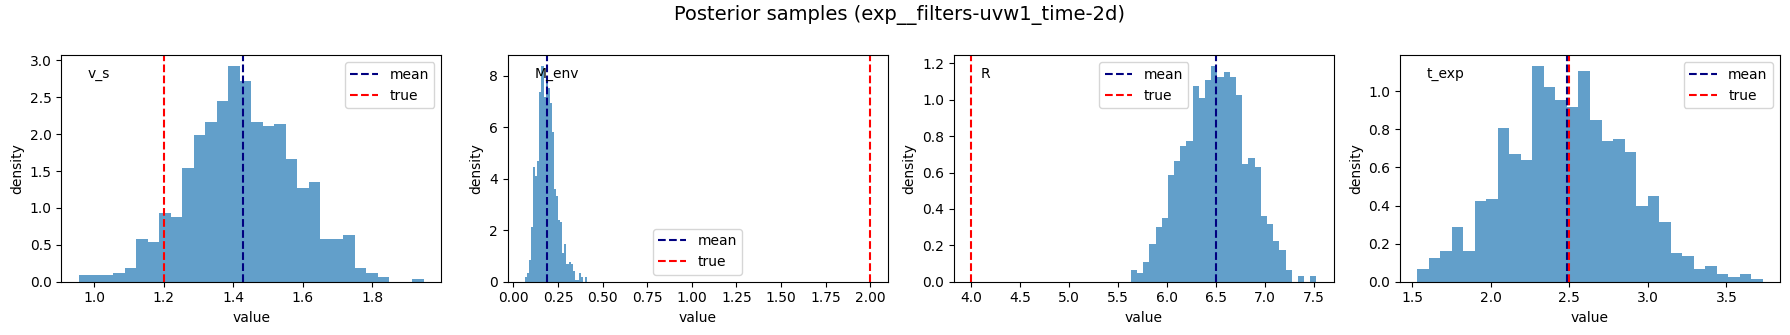

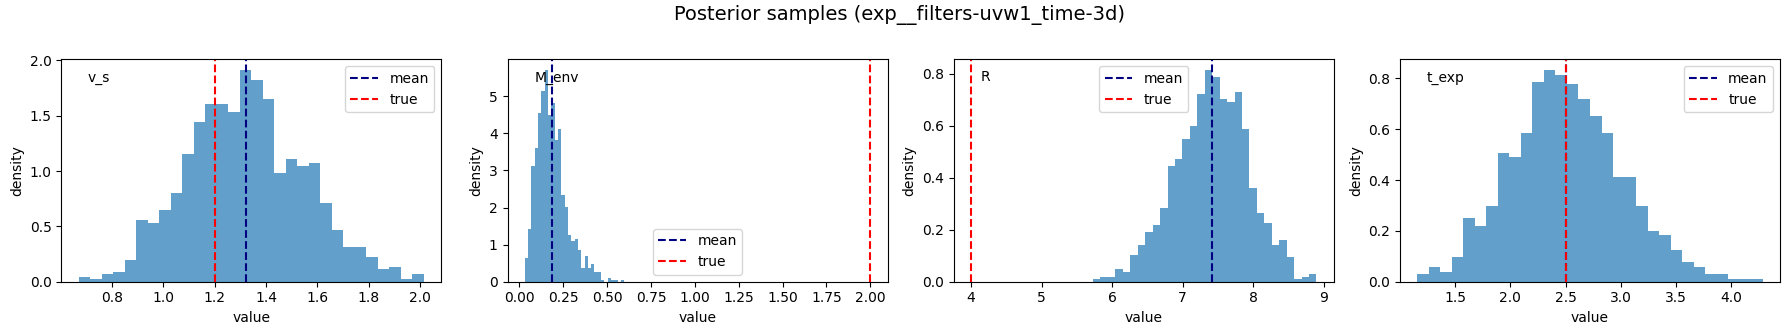

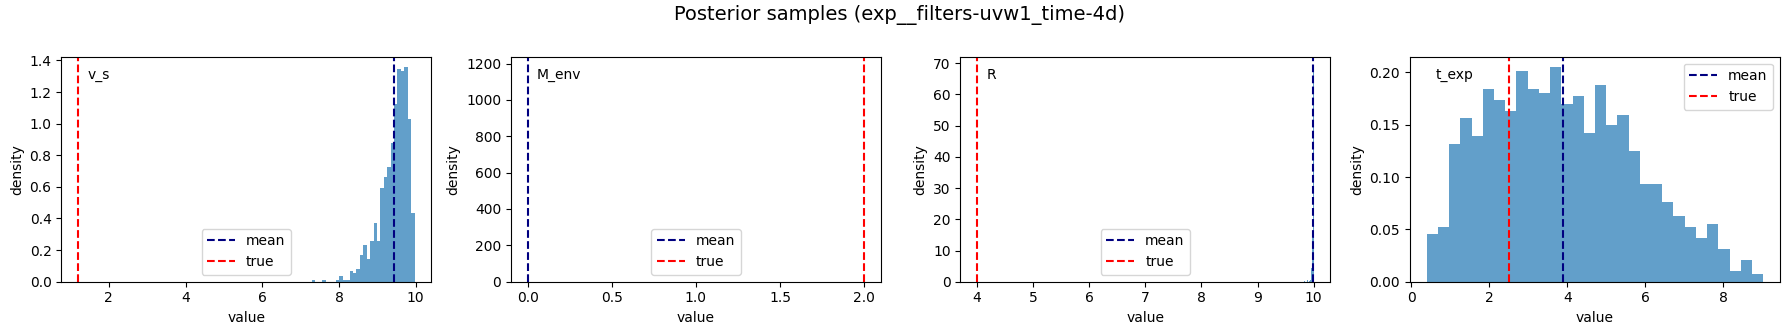

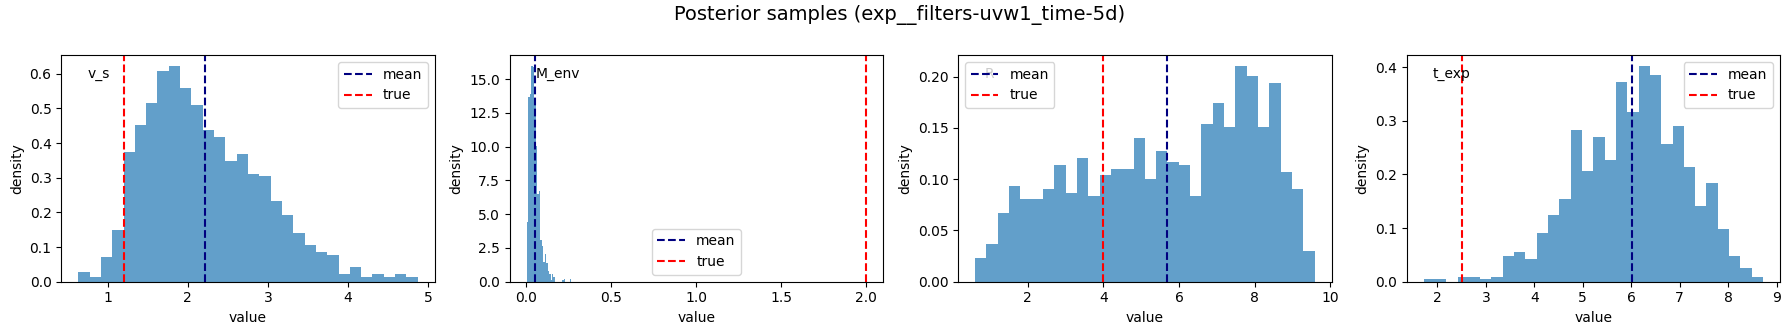

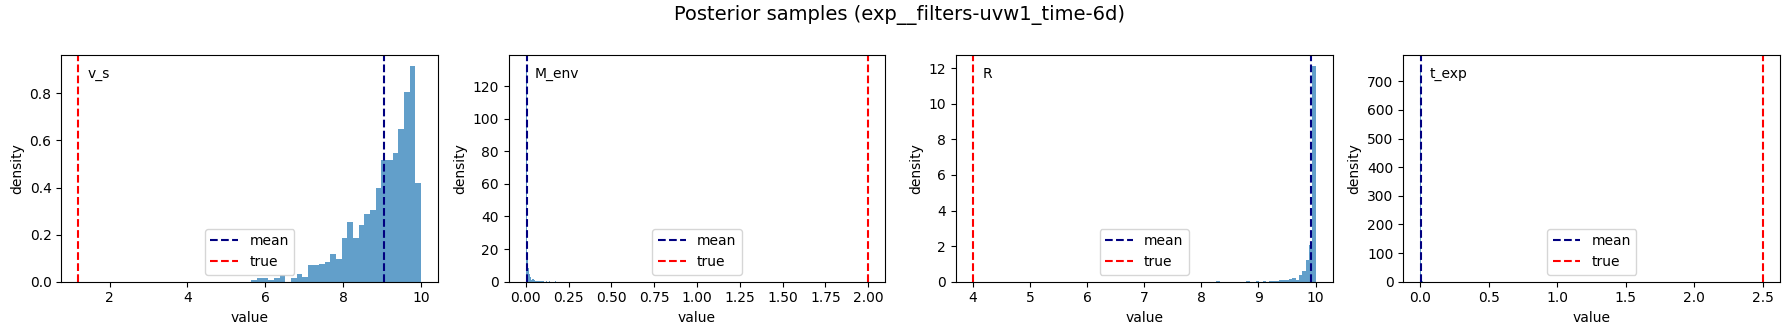

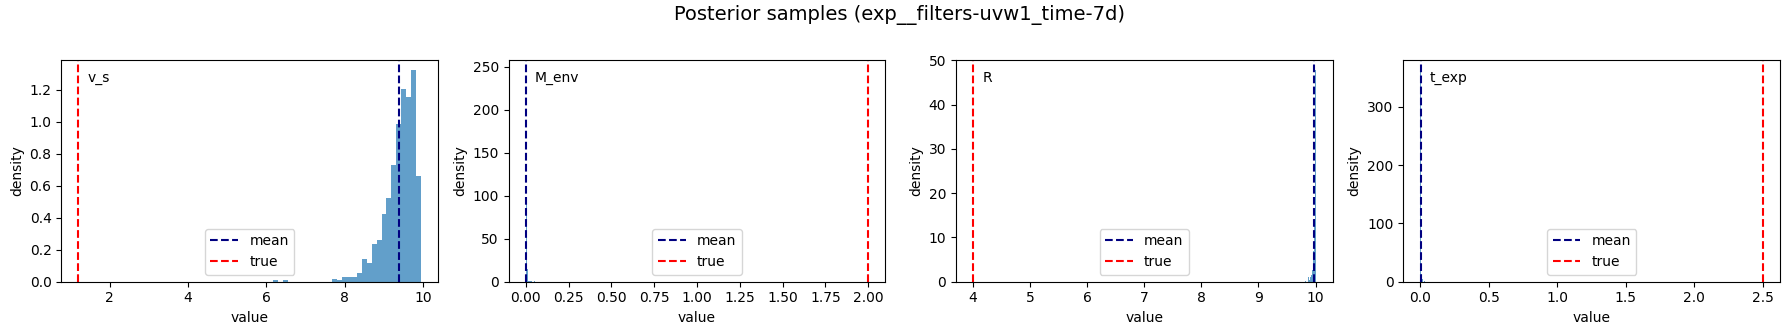

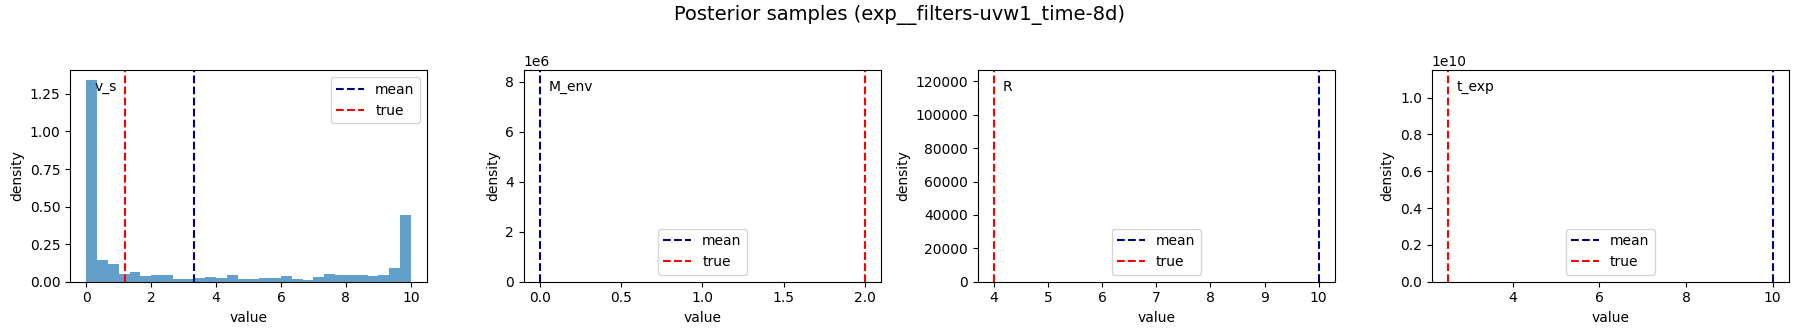

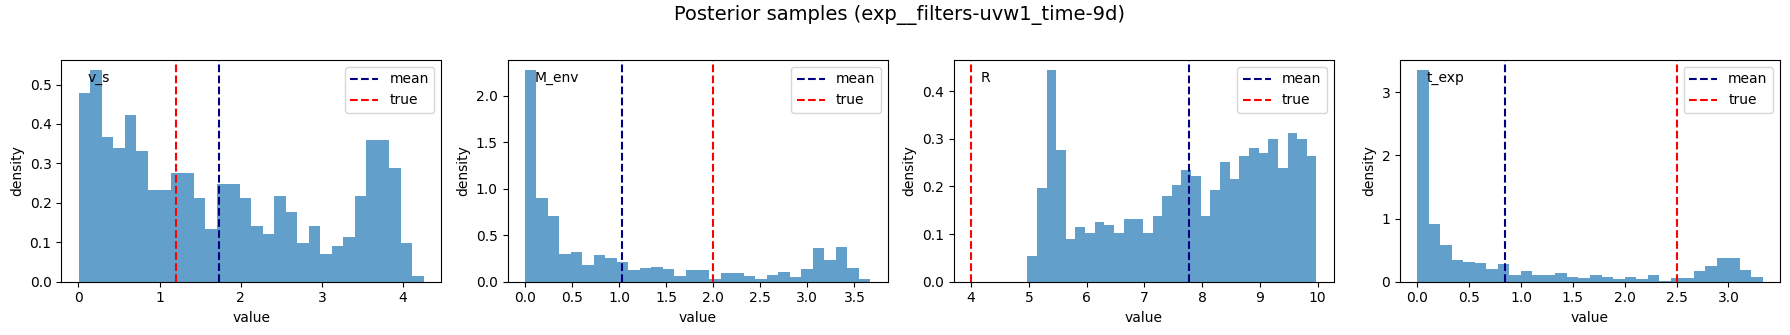

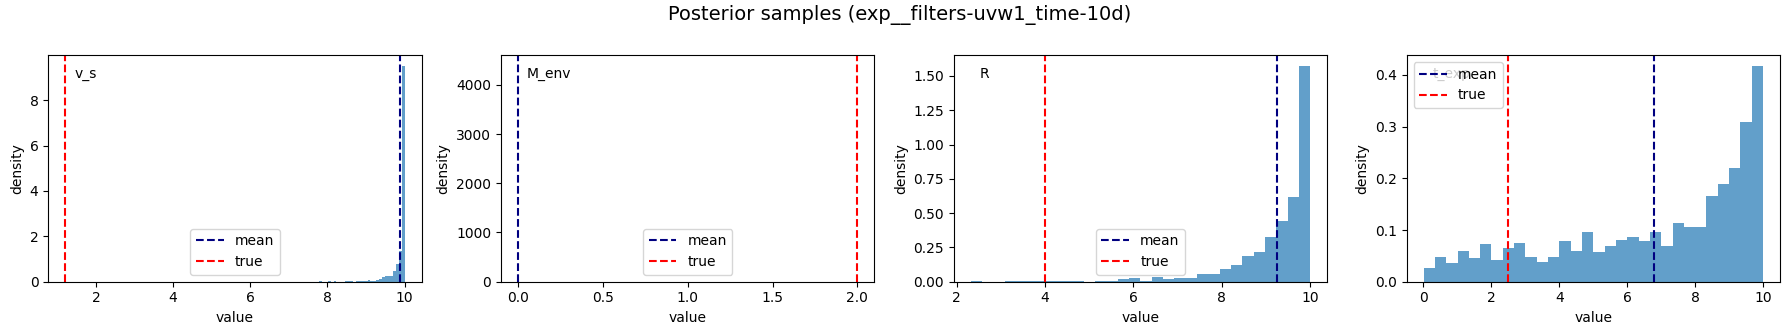

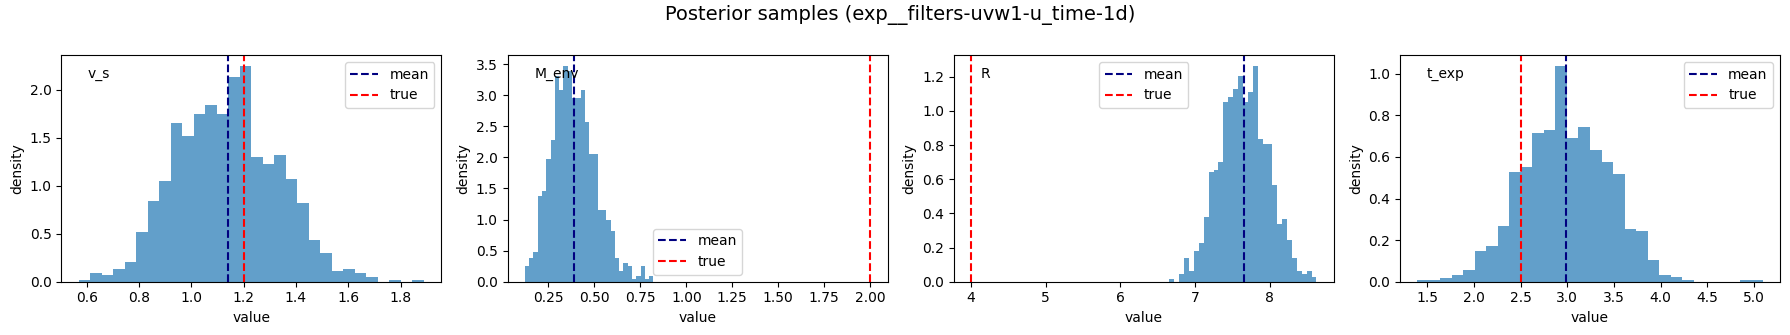

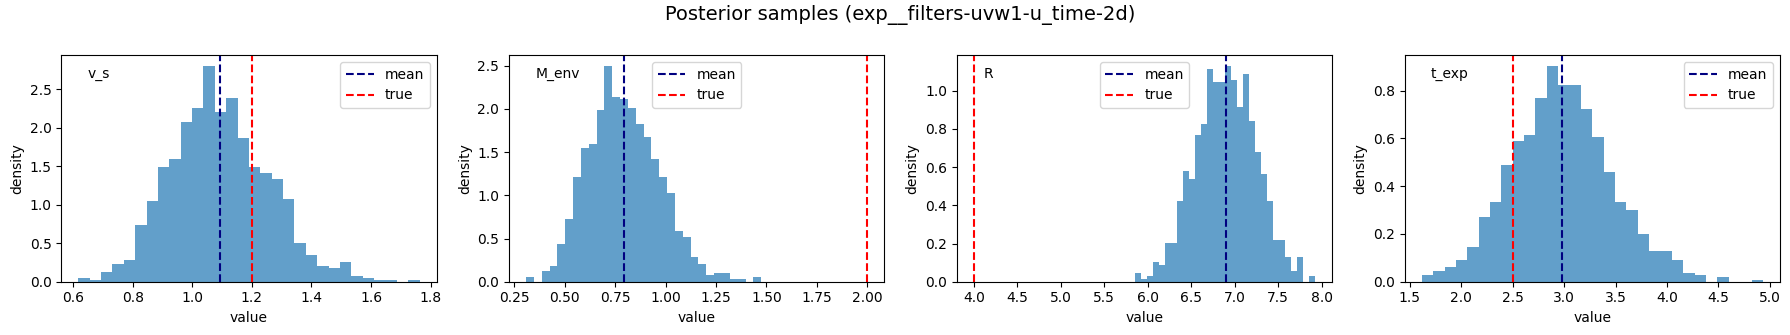

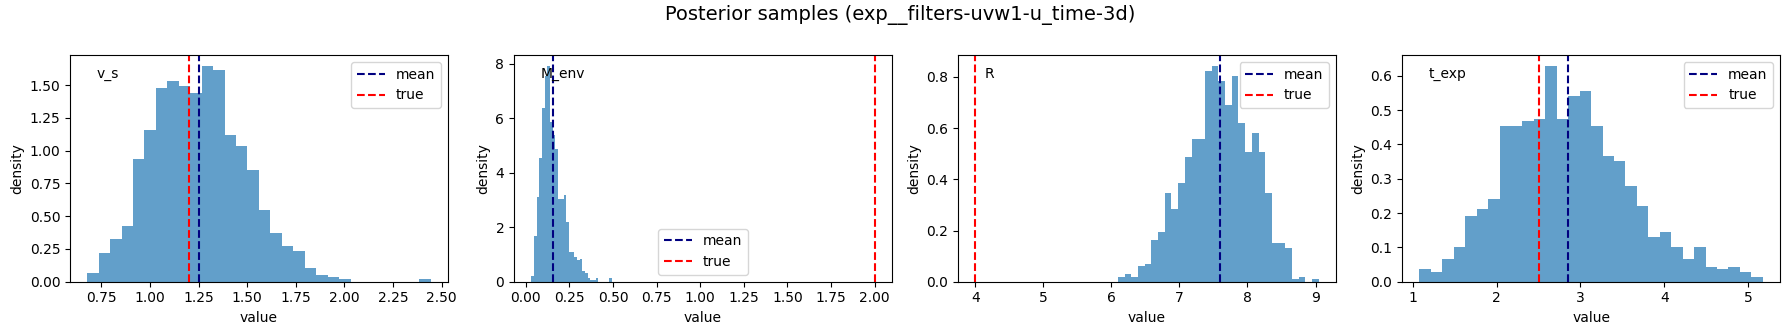

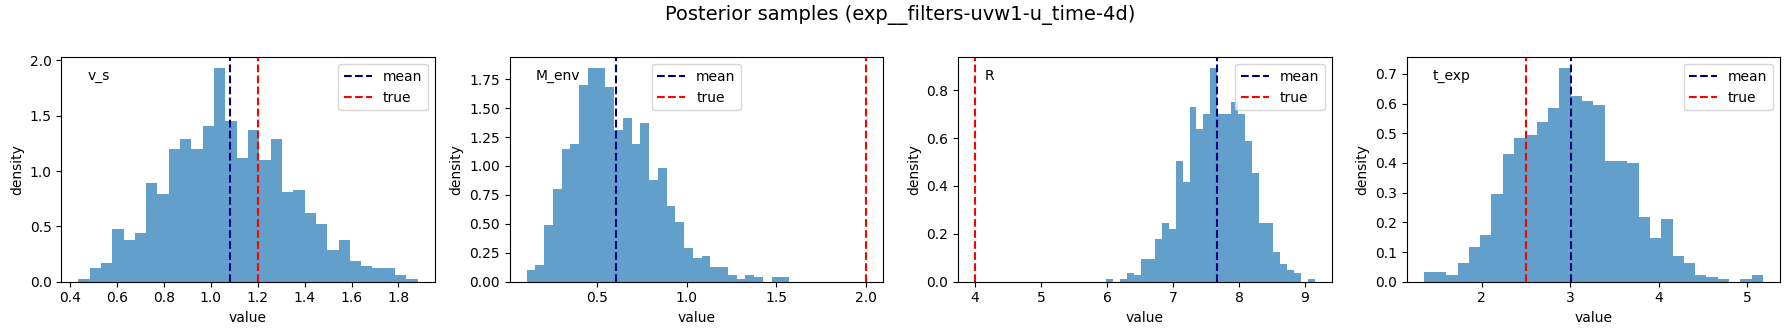

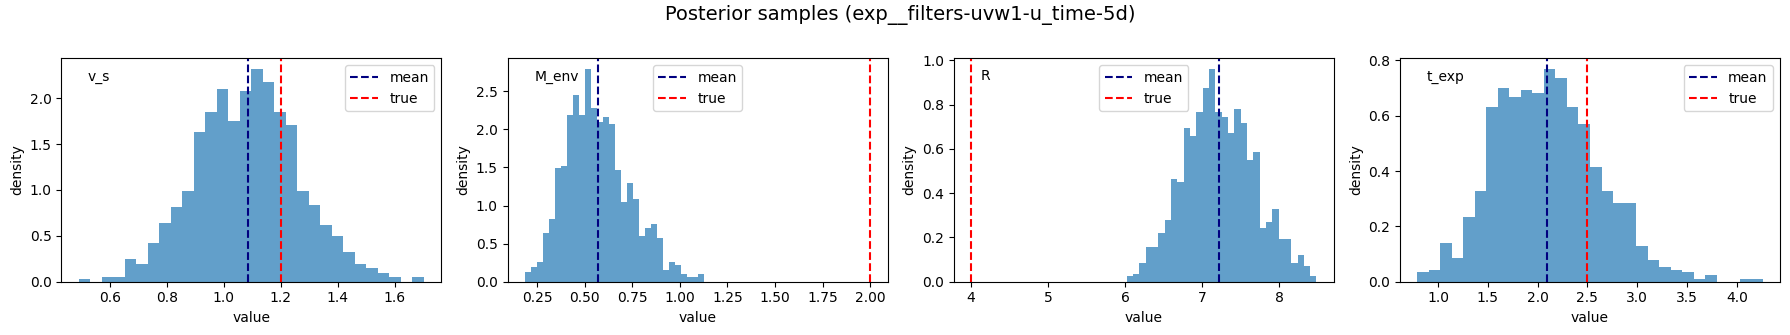

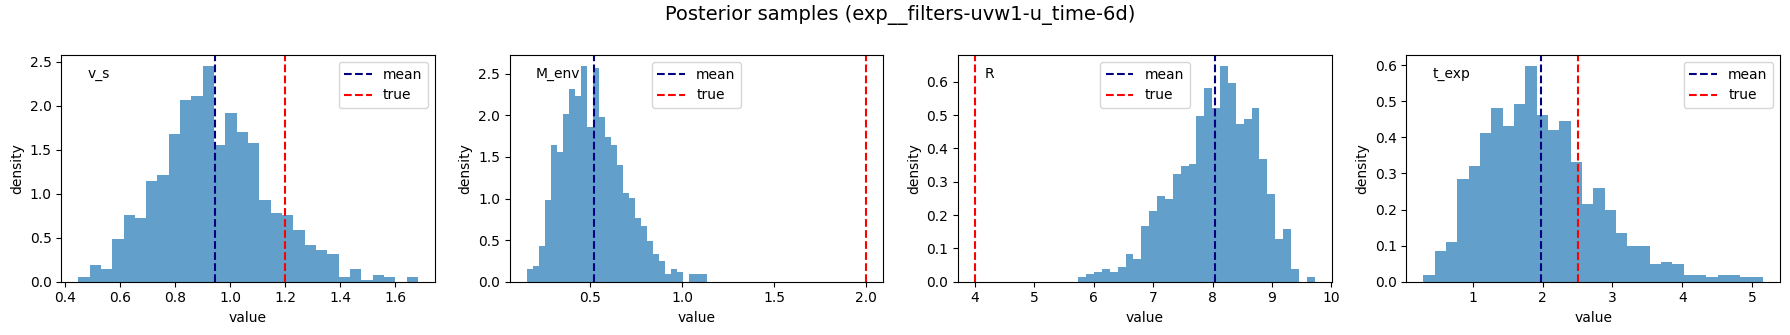

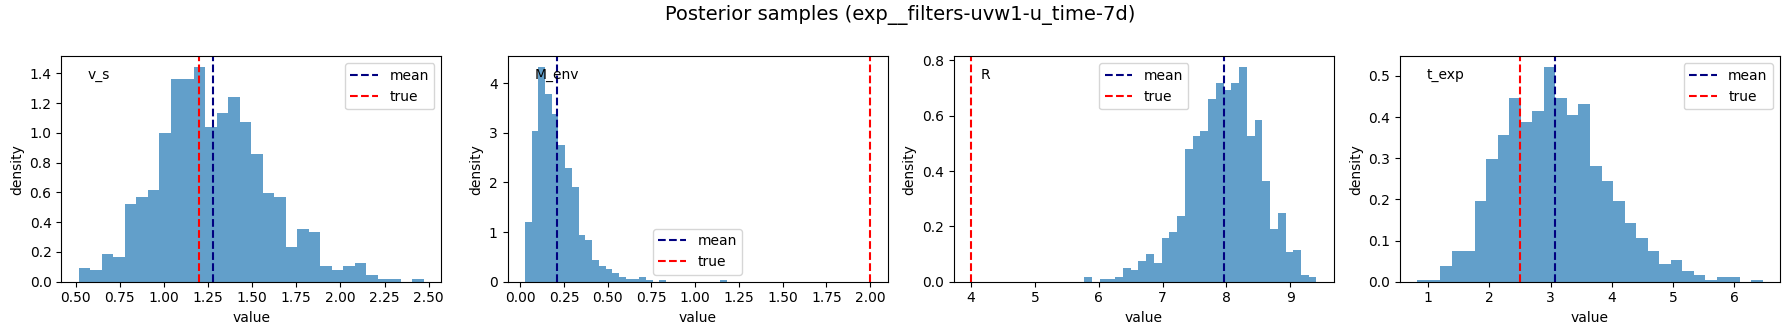

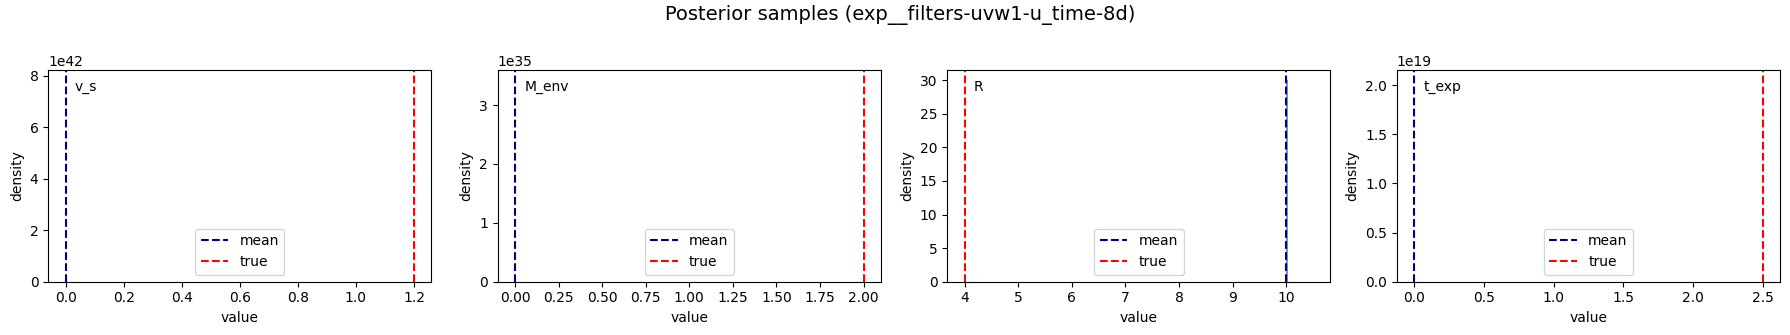

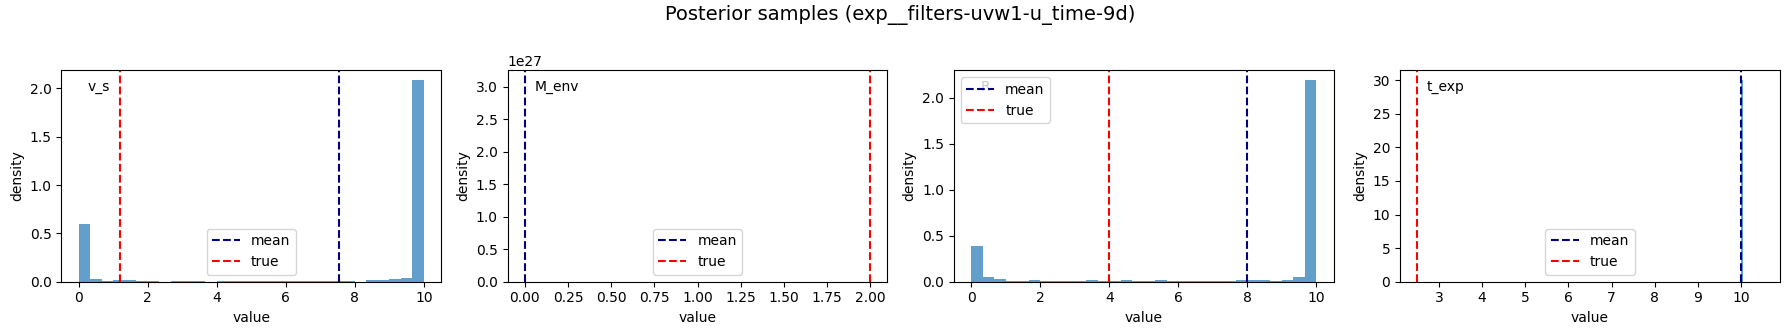

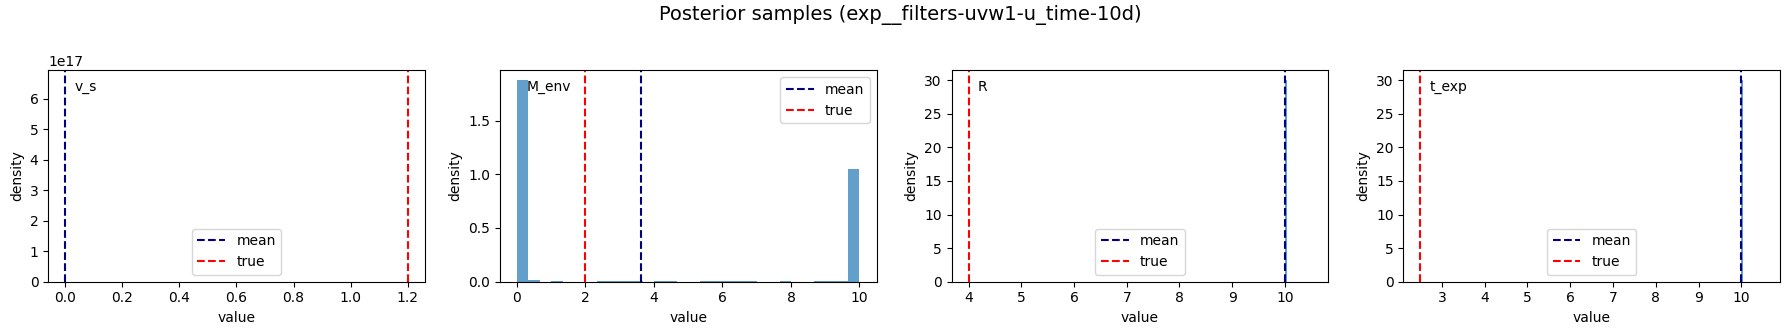

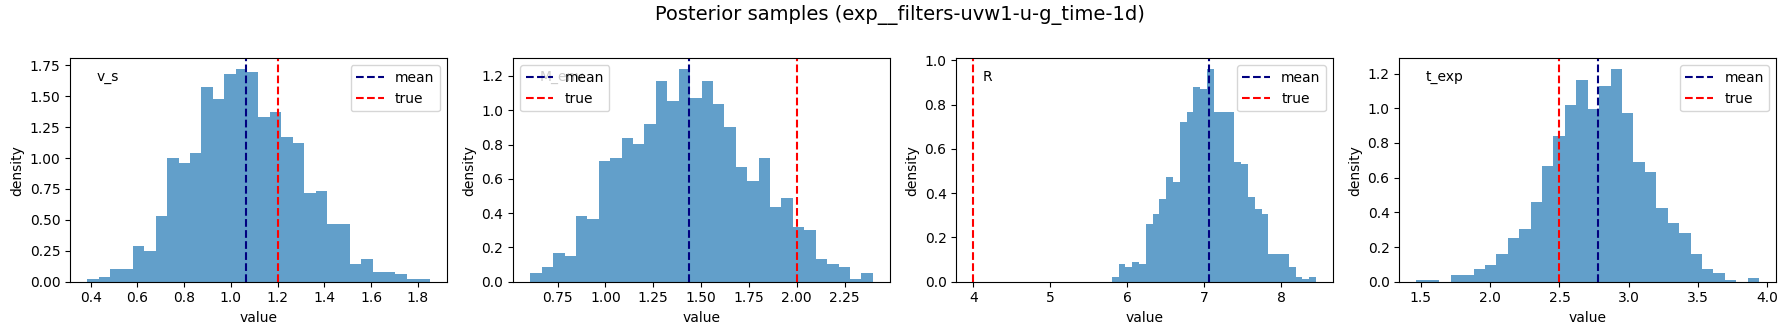

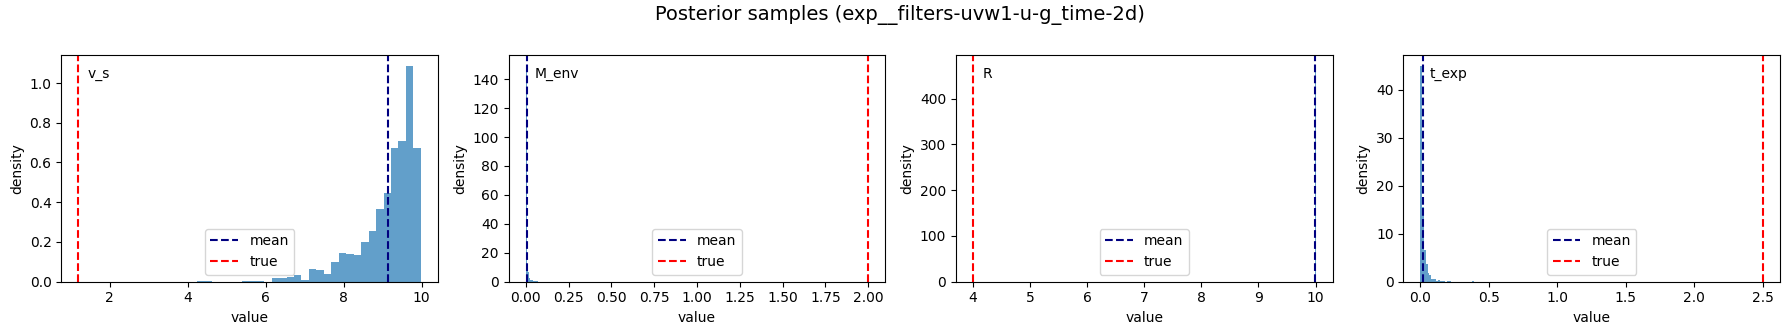

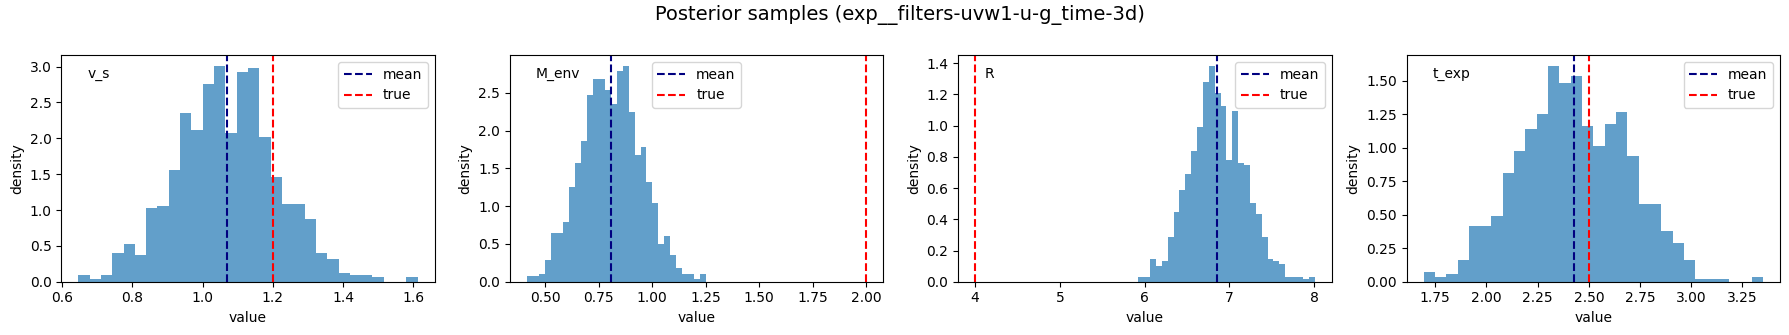

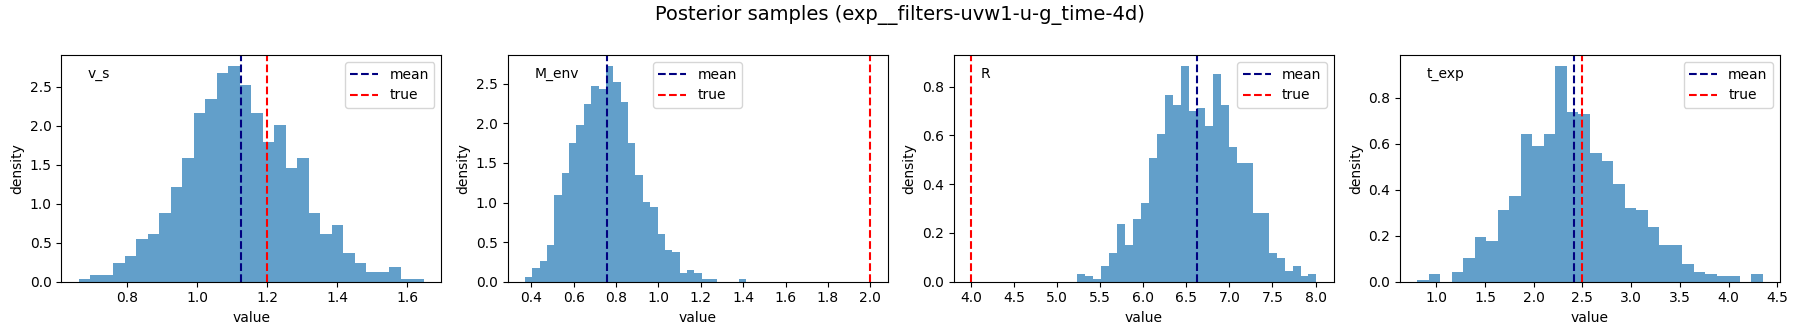

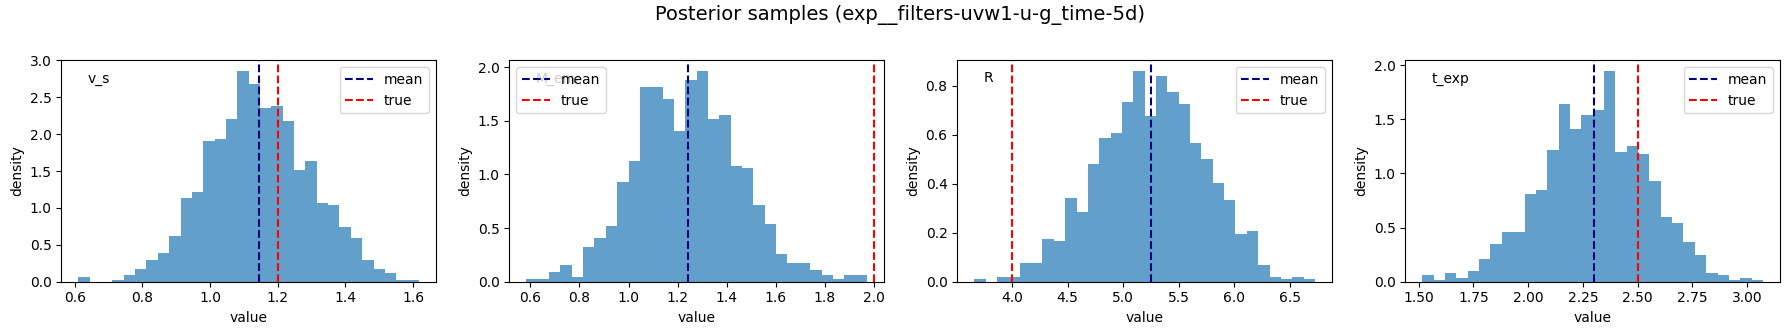

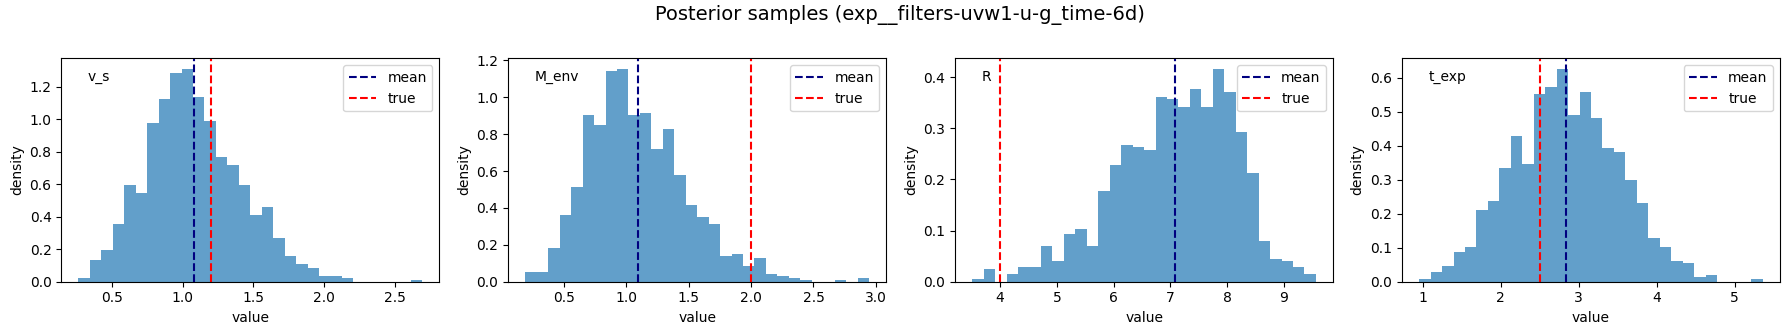

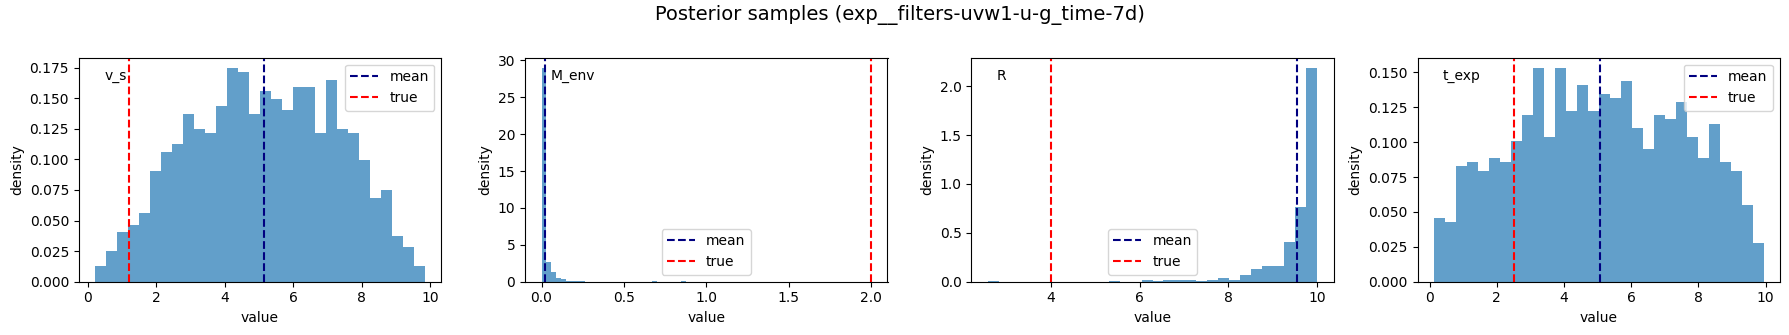

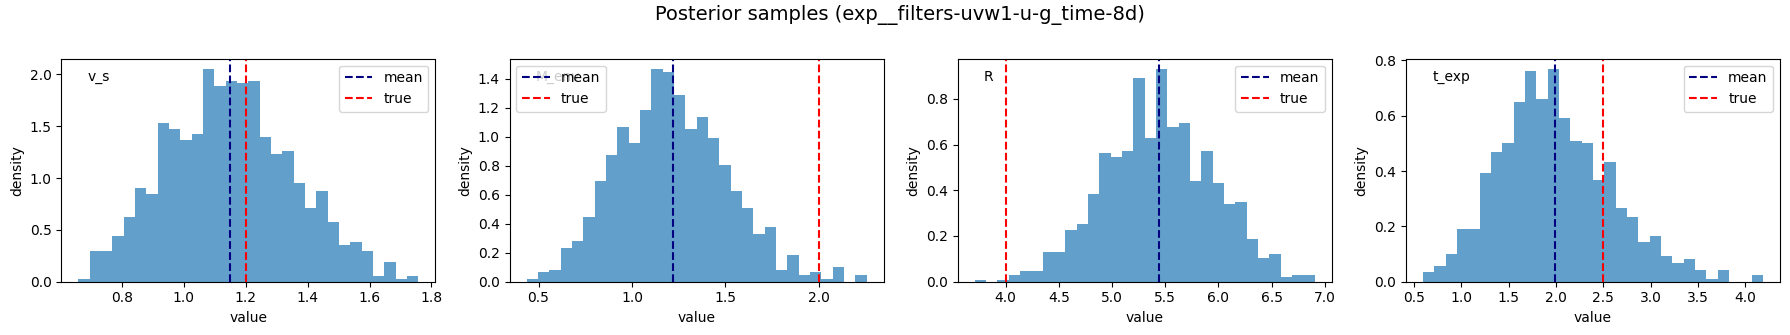

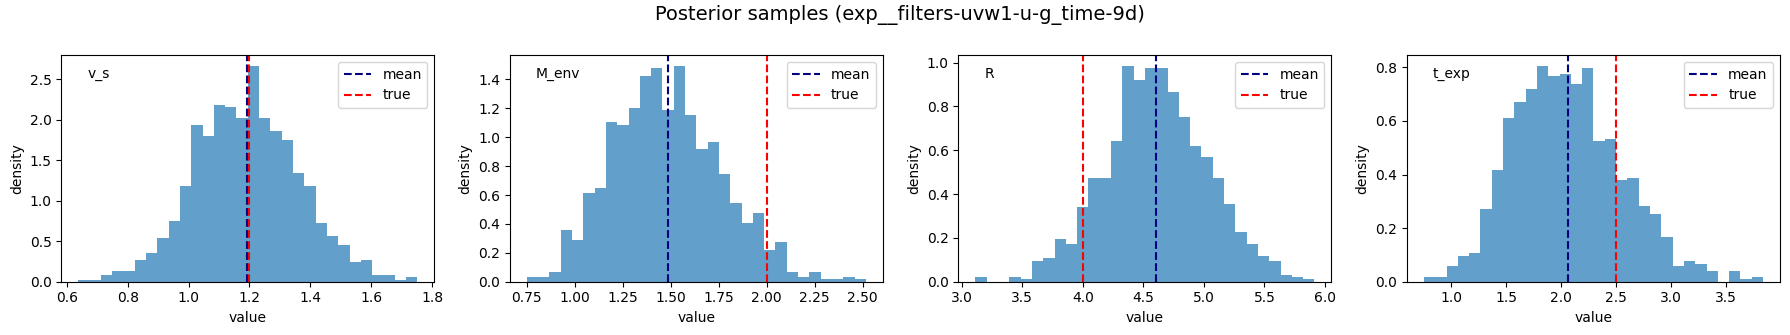

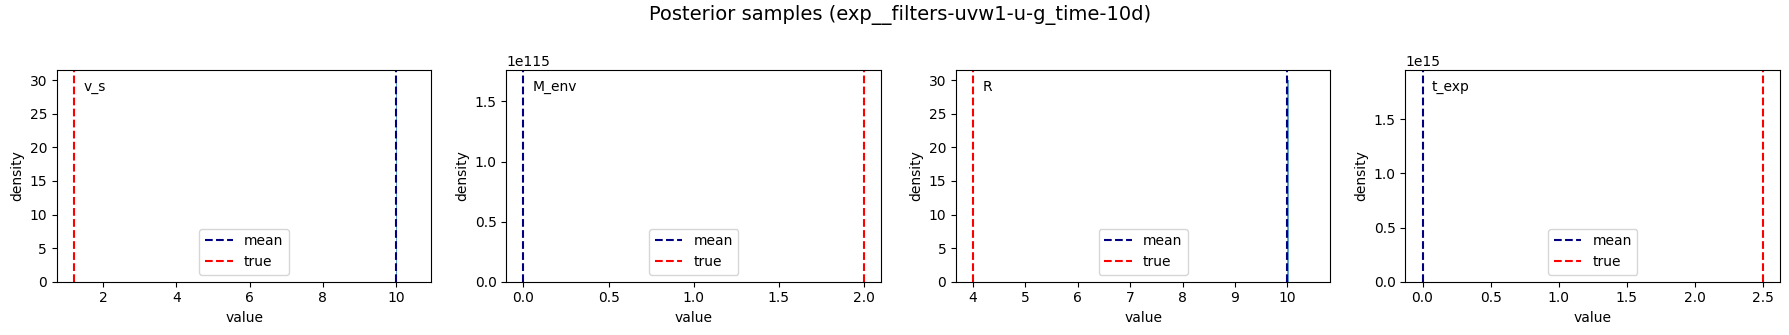

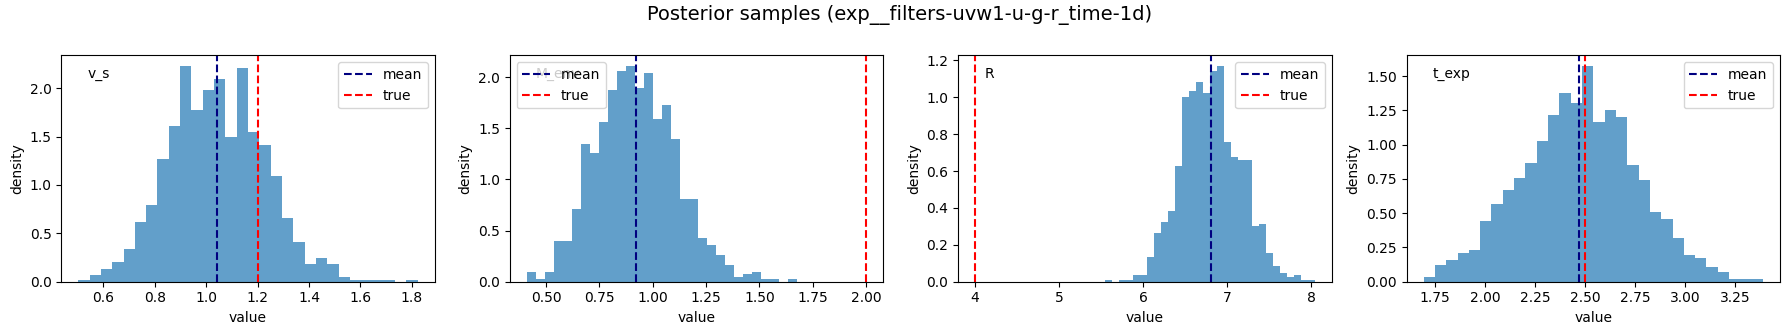

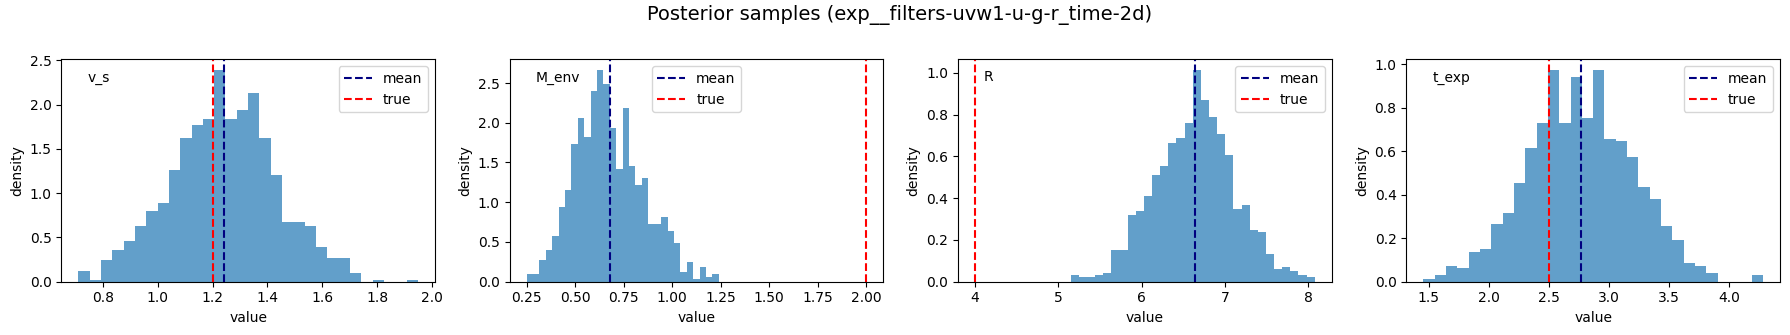

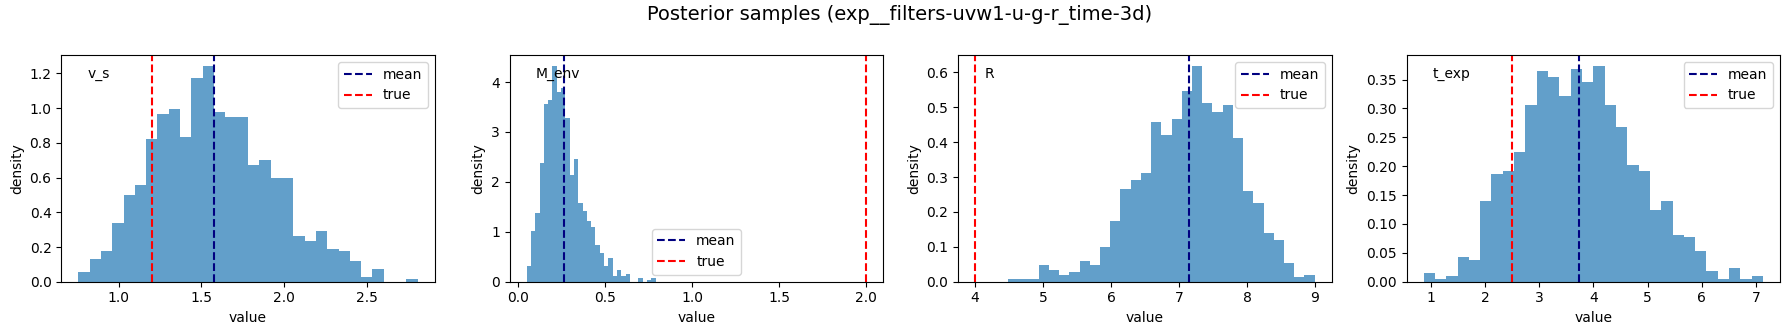

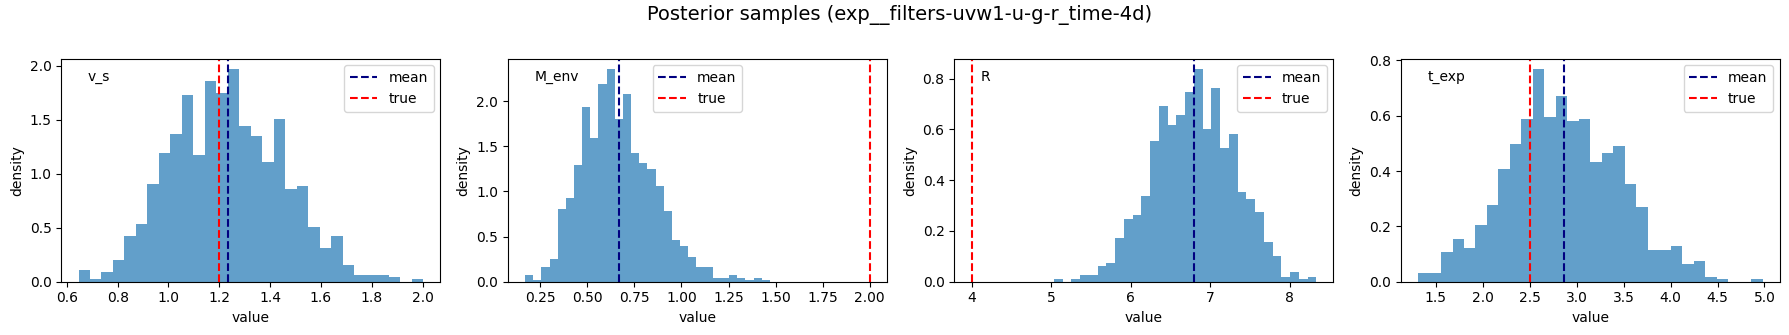

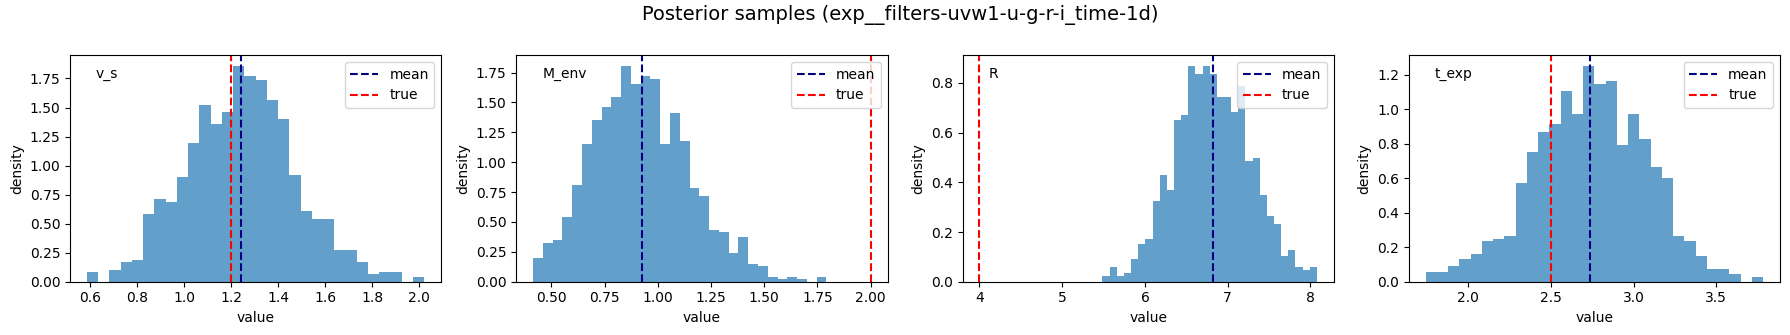

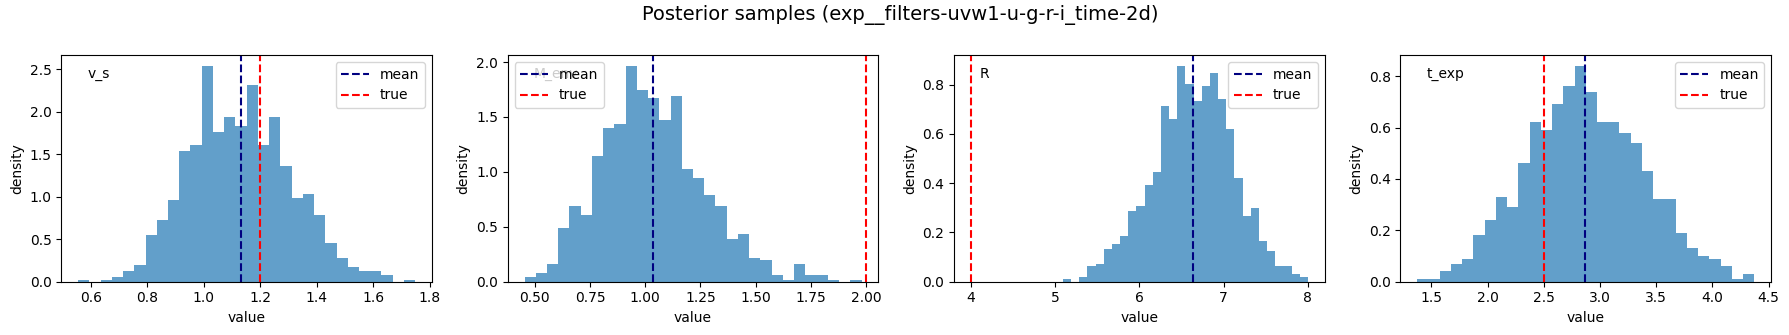

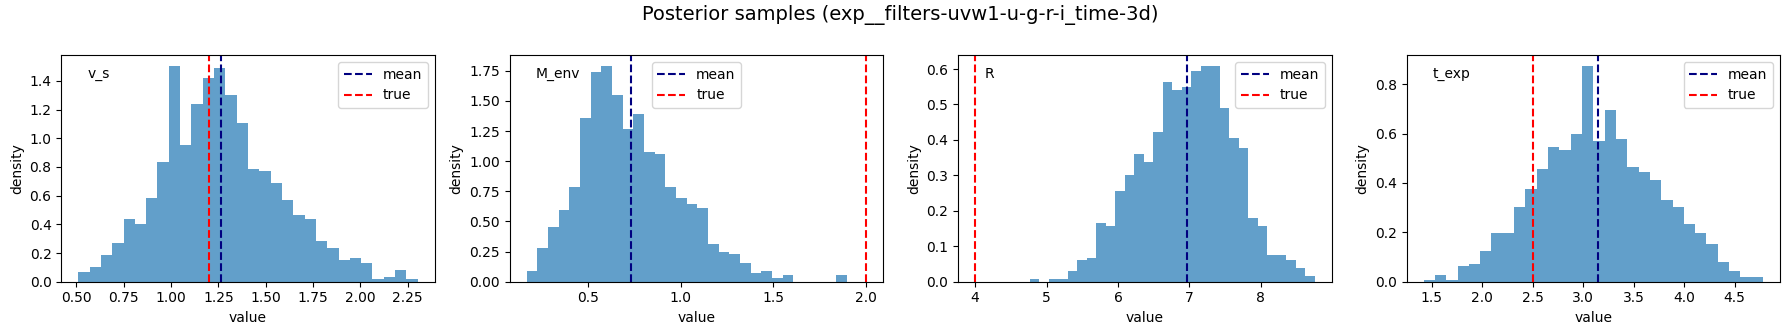

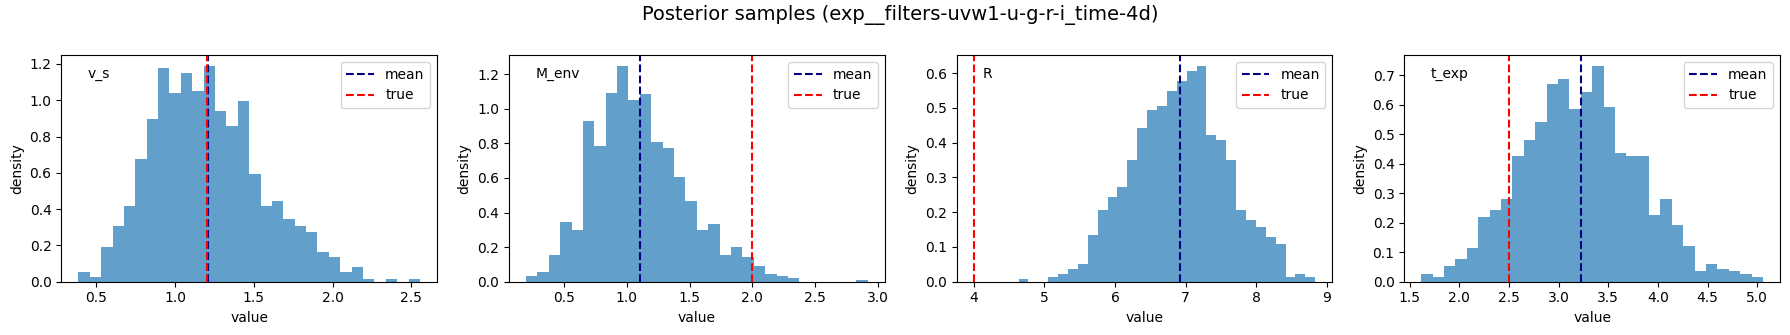

In [39]:

# ==============================================
# 📦 5. (Optional) Inspect posterior samples
# ==============================================

for expname in df["exp_name"]:
    example_exp = expname#df.iloc[-1]["exp_name"]
    samples_path = os.path.join(EXPERIMENTS_DIR, example_exp, "samples.npy")
    if os.path.exists(samples_path):
        samples = np.load(samples_path)
        param_names = ["v_s", "M_env",  "R", "t_exp"]
        mean = samples.mean(0)
        std = samples.std(0)
        true = builder.model_parameters
        fig, axes = plt.subplots(1, 4, figsize=(18, 3))
        for i, name in enumerate(param_names):
            axes[i].hist(samples[:, i], bins=30, density=True, color="tab:blue", alpha=0.7)
            axes[i].axvline(mean[i], color="navy", linestyle="--", label="mean")
            axes[i].axvline(true[i], color="red", linestyle="--", label="true")


            axes[i].annotate(name, xy=(.07,.9), xycoords="axes fraction")
            axes[i].set_xlabel("value")
            axes[i].set_ylabel("density")
            axes[i].legend()

        plt.tight_layout()
        # plt.show()
        plt.annotate(
            f"Posterior samples ({example_exp})",
            xy=(0.5, 1.1),
            xycoords="figure fraction",
            ha="center",
            va="top",
            fontsize=14
        )        
        plt.show()
    else:
        print("No samples.npy found in", example_exp)

In [ ]:
["z", "y", "i", "r", "g"]

['z', 'y', 'i', 'r', 'g']

In [ ]:
import seaborn as sns

# suponha que 'samples' seja [N, 4] com (v_s, M_env, R, t_0)
suffix = f'_filters-{"-".join(["z", "y", "i", "r", "g", "u"])}_time-{5}d'
ename = f"exp_{suffix}"
exp_dir = os.path.join(EXPERIMENTS_DIR, ename)
samples = np.load(os.path.join(exp_dir, "samples.npy"))
df = pd.DataFrame(samples, columns=["v_s", "M_env", "R", "t_0"])
sns.pairplot(df, corner=True, plot_kws=dict(alpha=0.3, s=10))
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/tf/astrodados2/pilca.storage/experiments/TEST_1/exp__filters-z-y-i-r-g-u_time-5d/samples.npy'